# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

## Part 1: Predicting criminal recidivism

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

> *Exercise 1:* Build a Decision Tree or a Random Forest. 
>   * Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.
>   * Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`:
>      * Which encoder did you choose? Describe what it does and why you chose it.
>   * Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.
>   * Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`. 
>      * Describe how the model you chose works and why you chose it.
>   * Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall. 
>      * What are your thoughts on these metrics? Is accuracy a good measure?
>   * Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?
>   * Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)
features = df.filter(column_list)
query_str = 'days_b_screening_arrest >= -30 & days_b_screening_arrest <= 30'
preprocessed = features.copy().query(query_str)
preprocessed.drop(["days_b_screening_arrest"], axis=1, inplace=True)
preprocessed.head()

,age,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid
0,69,Male,Other,0,0,0,0,0
1,34,Male,African-American,0,0,0,0,1
2,24,Male,African-American,0,0,1,4,1
5,44,Male,Other,0,0,0,0,0
6,41,Male,Caucasian,0,0,0,14,1


In [3]:
recommitted_values = preprocessed.two_year_recid.value_counts()
target_category_size = recommitted_values.min()
recommitted = preprocessed.query(f"two_year_recid == 1")[:target_category_size]
no_recommitted = preprocessed.query(f"two_year_recid == 0")[:target_category_size]
balanced = pd.concat([recommitted, no_recommitted], axis=0)
balanced.head()

,age,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid
1,34,Male,African-American,0,0,0,0,1
2,24,Male,African-American,0,0,1,4,1
6,41,Male,Caucasian,0,0,0,14,1
11,23,Male,African-American,0,0,0,3,1
14,47,Female,Caucasian,0,0,0,1,1


In [4]:
from sklearn.preprocessing import OneHotEncoder

sex = ['Female', 'Male']
race = ['African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American', 'Other']
feature_columns = ["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

def prep_features_and_targets(dataset):
    y = dataset["two_year_recid"]
    enc = OneHotEncoder(categories=[sex, race], handle_unknown='ignore')
    X_1 = dataset[["sex", "race"]]
    X_2 = dataset.filter(feature_columns)
    enc.fit(X_1)
    category_data = enc.transform(X_1).toarray()
    X = np.concatenate([category_data, X_2.to_numpy()], axis=1)
    return (X, y)

In [5]:
def compute_matrix(predictions, test_labels):
    # only 1 & 1 = 1
    true_positive = np.bitwise_and(predictions, test_labels).sum()
    # only ~(0 | 0) = 1
    true_negative = np.count_nonzero(np.bitwise_or(predictions, test_labels) == 0)

    diff = (predictions - test_labels).value_counts()
    # pred 0 - actual 1 is -1
    false_negative = diff[-1] if -1 in diff.index else 0
    
    # pred 1 - actual 0 is 1
    false_positive = diff[1] if 1 in diff.index else 0
    return [[true_positive, false_positive], [true_negative, false_negative]]

In [6]:
def performance_metrics(predictions, test_labels):
    [true_positive, false_positive], [true_negative, false_negative] = compute_matrix(predictions, test_labels)
    diff = (predictions - test_labels).value_counts()
    accuracy = diff[0] / len(predictions)
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return (accuracy, precision, recall)

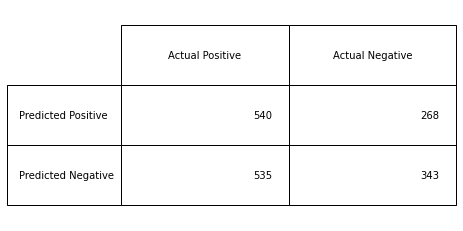

Accuracy: 0.64
Precision: 0.67
Recall: 0.61


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X, y = prep_features_and_targets(balanced)
train_features, test_features, train_labels, test_labels = train_test_split(X, y, train_size=0.7, test_size=0.3, shuffle=True, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(train_features, train_labels)
predictions = np.array(np.round(rf.predict(test_features)), dtype=np.int64)

fig, ax = plt.subplots()
ax.axis('off')
tableDataAll = compute_matrix(predictions, test_labels)
pred_labels = ["Predicted Positive", "Predicted Negative"]
ac_labels = ["Actual Positive", "Actual Negative"]
table = ax.table(cellText=tableDataAll, rowLabels=pred_labels, colLabels=ac_labels, loc="center")
table.scale(1, 5)

plt.show()
accuracy, precision, recall = performance_metrics(predictions, test_labels)
print(f"""Accuracy: {accuracy:.2}\nPrecision: {precision:.2}\nRecall: {recall:.2}""")

<mark>Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall.
What are your thoughts on these metrics? Is accuracy a good measure?<br>
Are your results tied to the specific hyperparameter set you used? Perform a RandomizedSearchCV and recompute the performance metric above with the hyperparameters found. What do you observe?<br>
Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?</mark><br>
<b>TODO<b>

Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

**N.B.** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

In [8]:
y_hat = predictions

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

>*Exercise 2.1:* A few questions about bias.
> * What are the most common types of data bias? 
> * What are the potential bias sources/types in our case-study (i.e. recidivism)?

<mark>What are the most common types of data bias?</mark><br>
>The most common types of data bias are:
>- Response / Activity Bias
>- Selection bias due to feedback loops
>- Bias due to system drift
>- Omitted variable bias
>- Societal bias

<mark>What are the potential bias sources in our case-study (i.e. recidivism)?</mark>
> Our data reflects the discrimination against African-Americans in the criminal justice system. This  is an example of societal bias.
>
> The dataset is also not representative of all demographic groups. This can be seen from the low number of records associated with Asians and Native-Americans, which skew statistics and predicitions computed on these groups. This is a case of activity bias.

> *Exercise 2.2:* Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.
>
>    * Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:
>
>$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 
>
>
>   * To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3).
>      * Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find? 
>   * Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
>      * **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
>      * **Hint 2** You shouldn't rerun your model!
>   * Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
def train_and_test_random_forest(dataset):
    X, y = prep_features_and_targets(dataset)
    train_features, test_features, train_labels, test_labels = train_test_split(X, y, train_size=0.7, test_size=0.3, shuffle=True, random_state=42, stratify=y)
    rf.fit(train_features, train_labels)
    probs = rf.predict(test_features)
    return (probs, test_labels)


In [10]:
# This function takes as input a recidivism probability and a threshold
# and returns the prediction of the model
# This is the implementation of Eq.(1) from Exercise 2.2 for a single element
def predict_using_th_elementwise(probability, th):
    if probability > th:
        return 1
    return 0
# Given the probability vector and a threshold, the vectorized function returns y_hat
predict_using_threshold = np.vectorize(predict_using_th_elementwise)

# This function takes as input the target values and the predicted values of recidivism
# and returns the true positive and false positive rates.
def compute_rates(test_labels, probs):
    # Compute the values of the confusion matrix by comparing predicted and actual values
    [true_positive, false_positive], [true_negative, false_negative] = compute_matrix(probs, test_labels)
    true_positive_rate = true_positive / (true_positive + false_negative)
    false_positive_rate = false_positive / (false_positive + true_negative)
    return (true_positive_rate, false_positive_rate)

#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y, y_probs, ths):
    #initialize roc as an empty np.array
    roc = np.array([])
    #loop over thresholds
    for th in ths:
        #convert y_prob in y_hat
        y_hat = predict_using_threshold(y_probs, th)
        #compute TPR and FPR
        TPR, FPR = compute_rates(y, y_hat)
        #add threshold and point to roc array
        roc = np.append(roc, [th, FPR, TPR])
    #return roc
    return roc.reshape(-1, 3)

In [11]:
pCA = balanced.loc[balanced.race == "Caucasian"]
pAA = balanced.loc[balanced.race == "African-American"]


ths = np.linspace(1e-5,1-1e-5, 10)
y_prob_ca, test_labels_ca = train_and_test_random_forest(pCA)
roc_ca = roc_curve(test_labels_ca, y_prob_ca, ths)

y_prob_aa, test_labels_aa = train_and_test_random_forest(pAA)
roc_aa = roc_curve(test_labels_aa, y_prob_aa, ths)

In [12]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, Legend

output_notebook()

Loading BokehJS ...

In [13]:
column_list = ["FPR_AA", "TPR_AA", "FPR_CA", "TPR_CA"]
rates_data = np.concatenate((roc_aa[:, 1:], roc_ca[:, 1:]), axis=1)
df_roc = pd.DataFrame(rates_data, columns=column_list)

x = np.concatenate((roc_aa[:, 1:2], roc_ca[:, 1:2]), axis=0)
y = np.concatenate((roc_aa[:, 2:], roc_ca[:, 2:]), axis=0)
th = np.concatenate((roc_aa[:, :1], roc_ca[:, :1]), axis=0)
df_helper = pd.DataFrame(np.concatenate((x, y, th), axis=1), columns=["x", "y", "th"])
helper_source = ColumnDataSource(df_helper)

source = ColumnDataSource(df_roc)
p = figure(title="True positive and false positive rates for different thresholds", x_axis_label="FPR", y_axis_label="TPR")

l_aa = p.line(x="FPR_AA",  y="TPR_AA", source=source, color="blue")
l_ca = p.line(x="FPR_CA",  y="TPR_CA", source=source, color="red")

legend = Legend(items=[("African-Americans", [l_aa]), ("Caucasians", [l_ca])], location="top")
p.add_layout(legend, 'right')
#
p.legend.click_policy="hide"

cr = p.circle('x','y', source=helper_source, fill_color='grey', hover_fill_color='orange')
p.add_tools(HoverTool(tooltips=[('Threshold', '@th')], renderers=[cr]))
show(p)

<b>Choosing threshold:</b>

In [14]:
th_aa = 0.889
th_ca = 0.778
y_hat_ca = predict_using_threshold(y_prob_ca, th_ca)
y_hat_aa = predict_using_threshold(y_prob_aa, th_aa)

In [33]:
for th in ths:
    th_aa = th
    th_ca = th
    y_hat_aa = predict_using_threshold(y_prob_aa, th_aa)
    y_hat_ca = predict_using_threshold(y_prob_ca, th_ca)    
    eact_rec_rate_CA = np.count_nonzero(test_labels_ca == 1) / len(test_labels_ca)
    act_rec_rate_AA = np.count_nonzero(test_labels_aa == 1) / len(test_labels_aa)

    equal_odds_rec_rate_CA = np.count_nonzero(y_hat_ca == 1) / len(y_hat_ca)
    equal_odds_rec_rate_AA = np.count_nonzero(y_hat_aa == 1) / len(y_hat_aa)
    diffaa = (equal_odds_rec_rate_AA - act_rec_rate_AA) * 100
    diffca = (equal_odds_rec_rate_CA - act_rec_rate_CA) * 100
    print(f"Threshold: {th:<15.6}DiffAA: {diffaa:<10.2f} DiffCA: {diffca:.2f}%")

Threshold: 1e-05          DiffAA: 42.48      DiffCA: 53.00%
Threshold: 0.111119       DiffAA: 36.56      DiffCA: 43.46%
Threshold: 0.222228       DiffAA: 29.38      DiffCA: 26.86%
Threshold: 0.333337       DiffAA: 20.27      DiffCA: 17.31%
Threshold: 0.444446       DiffAA: 9.23       DiffCA: 6.18%
Threshold: 0.555554       DiffAA: -6.83      DiffCA: -4.24%
Threshold: 0.666663       DiffAA: -15.60     DiffCA: -12.90%
Threshold: 0.777772       DiffAA: -28.93     DiffCA: -24.38%
Threshold: 0.888881       DiffAA: -37.02     DiffCA: -33.04%
Threshold: 0.99999        DiffAA: -52.96     DiffCA: -41.87%


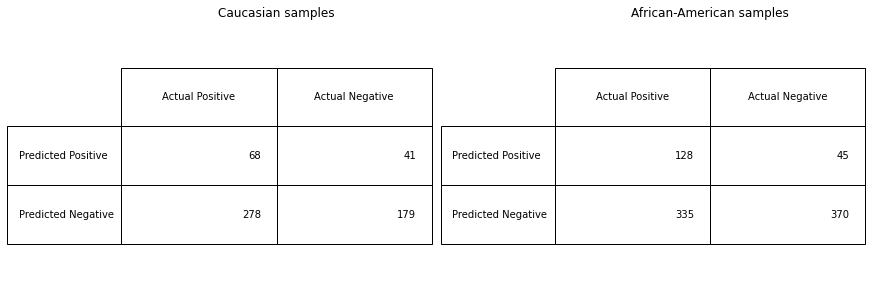

In [45]:
equalOddsTableCA = compute_matrix(y_hat_ca, test_labels_ca)
equalOddsTableAA = compute_matrix(y_hat_aa, test_labels_aa)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs[0].set_title("Caucasian samples")
axs[1].set_title("African-American samples")
axs[0].axis('off')
axs[1].axis('off')

tableCA = axs[0].table(cellText=equalOddsTableCA, rowLabels=pred_labels, colLabels=ac_labels, loc="center")
tableAA = axs[1].table(cellText=equalOddsTableAA, rowLabels=pred_labels, colLabels=ac_labels, loc="center")
tableAA.scale(1, 4)
tableCA.scale(1, 4)
plt.show()

act_rec_rate_CA = np.count_nonzero(test_labels_ca == 1) / len(test_labels_ca)
act_rec_rate_AA = np.count_nonzero(test_labels_aa == 1) / len(test_labels_aa)

equal_odds_rec_rate_CA = np.count_nonzero(y_hat_ca == 1) / len(y_hat_ca)
equal_odds_rec_rate_AA = np.count_nonzero(y_hat_aa == 1) / len(y_hat_aa)

In [46]:
def precision_str(metrics):
    return [f"{(m * 100):.0f}%" for m in metrics]

original_metrics_ca = precision_str(performance_metrics(np.round(y_prob_ca).astype(int), test_labels_ca))
debiased_metrics_ca = precision_str(performance_metrics(y_hat_ca, test_labels_ca))
metrics_ca = list(zip(original_metrics_ca, debiased_metrics_ca))

original_metrics_aa = precision_str(performance_metrics(np.round(y_prob_aa).astype(int), test_labels_aa))
debiased_metrics_aa = precision_str(performance_metrics(y_hat_aa, test_labels_aa))
metrics_aa = list(zip(original_metrics_aa, debiased_metrics_aa))

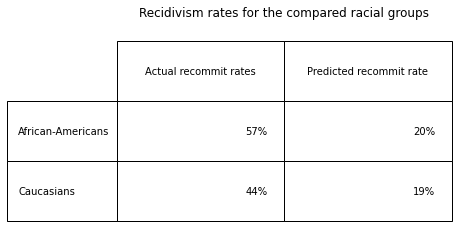

In [47]:
act_rec_rate_CA = np.count_nonzero(test_labels_ca == 1) / len(test_labels_ca)
act_rec_rate_AA = np.count_nonzero(test_labels_aa == 1) / len(test_labels_aa)

equal_odds_rec_rate_CA = np.count_nonzero(y_hat_ca == 1) / len(y_hat_ca)
equal_odds_rec_rate_AA = np.count_nonzero(y_hat_aa == 1) / len(y_hat_aa)

races = ["African-Americans", "Caucasians"]
rates_l = ["Actual recommit rates", "Predicted recommit rate"]
rates_data = [[ f"{act_rec_rate_AA*100:.0f}%", f"{equal_odds_rec_rate_AA*100:.0f}%"],
              [f"{act_rec_rate_CA*100:.0f}%", f"{equal_odds_rec_rate_CA*100:.0f}%"]]

fig, ax = plt.subplots()
ax.set_title("Recidivism rates for the compared racial groups")
ax.axis('off')
table_rates = ax.table(cellText=rates_data, rowLabels=races, colLabels=rates_l, loc="center")
table_rates.scale(1, 5)
plt.show()

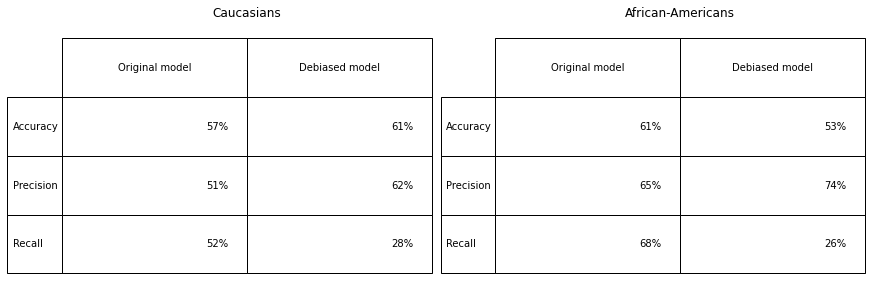

In [48]:
metrics_l = ["Accuracy", "Precision", "Recall"]
models_l = ["Original model", "Debiased model"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs[0].set_title("Caucasians")
axs[1].set_title("African-Americans")
axs[0].axis('off')
axs[1].axis('off')
table_metrics_ca = axs[0].table(cellText=metrics_ca, rowLabels=metrics_l, colLabels=models_l, loc="center")
table_metrics_aa = axs[1].table(cellText=metrics_aa, rowLabels=metrics_l, colLabels=models_l, loc="center")
table_metrics_ca.scale(1, 4)
table_metrics_aa.scale(1, 4)
plt.show()

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# ADD YOUR TITLE HERE

**Introduction.** Write your introduction here. Think about the audience. This is an article for the general public, so you should try to make it engaging, relatable, not too technical etc.

In [17]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

**Results from exploratory data analysis.** Write this section here. The aim is to show that the data is biased, which might have an impact on the model. Relate this part to the first visualization.

In [18]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

**Results from the classification task.** Write this section here. The aim is to show that the model is biased as it is learning from biased data. Relate this part to the second visualization.

In [19]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)

**Results from debiasing method.** Write this section here. The aim is to show that there are methods that can help to enhance fairness in cases as this one. Relate this part to the third visualization.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.

**References.** Any article need good sources! Whenever you make a statement, refer to data sources, previous studies, methods, etc. add a reference. 

1. reference 1
2. reference 2
3. reference 3
4. etc.

**Assignment Contributions**:

* id1
* id2
* id3